<a href="https://colab.research.google.com/github/Jundo22l/CAU_internship/blob/main/FCN%2BVOC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import os
from PIL import Image
import numpy as np

# VOC 데이터셋 다운로드 및 준비
root_dir = './'
voc_dataset = datasets.VOCSegmentation(root=root_dir, year='2012', image_set='train', download=True)

100%|██████████| 1999639040/1999639040 [01:33<00:00, 21382152.99it/s]


Extracting ./VOCtrainval_11-May-2012.tar to ./


In [ ]:
# Custom Dataset 클래스 정의
class VOCDataset(Dataset):
    def __init__(self, root, image_set='train', transform=None, target_transform=None):
        """
        데이터셋 초기화 메서드
        :param root: 데이터셋이 저장된 루트 디렉토리 경로
        :param image_set: 사용할 이미지셋 ('train' 또는 'val')
        :param transform: 입력 이미지에 적용할 변환
        :param target_transform: 타겟(마스크)에 적용할 변환
        """
        self.root = root
        self.image_set = image_set
        self.transform = transform
        self.target_transform = target_transform
        voc_root = os.path.join(self.root, 'VOCdevkit/VOC2012') #경로 저장
        self.image_dir = os.path.join(voc_root, 'JPEGImages') #폴더 저장
        self.mask_dir = os.path.join(voc_root, 'SegmentationClass')
        self.image_sets_file = os.path.join(voc_root, 'ImageSets/Segmentation', f'{self.image_set}.txt')

        # 이미지와 마스크 파일 경로 리스트 생성
        with open(self.image_sets_file, "r") as f: # 데이터셋 파일 읽어오기
            file_names = f.read().splitlines()

        self.image_names = [os.path.join(self.image_dir, x + ".jpg") for x in file_names]
        self.mask_names = [os.path.join(self.mask_dir, x + ".png") for x in file_names]

    def __len__(self):
        """
        데이터셋의 크기 반환 메서드
        :return: 데이터셋에 포함된 이미지 개수
        """
        return len(self.image_names)

    def __getitem__(self, idx):
        """
        인덱스에 해당하는 이미지와 마스크 반환 메서드
        :param idx: 데이터셋 인덱스
        :return: 변환된 이미지와 마스크
        """
        img = Image.open(self.image_names[idx]).convert('RGB') #이미지를 RGB 형식으로 변환
        mask = Image.open(self.mask_names[idx]) #이미지에 해당하는 mask 지정

        # 이미지와 마스크에 변환 적용
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            mask = self.target_transform(mask)

        # 마스크를 numpy 배열로 변환 후, Tensor로 변환 (mask 의 각 pixel 은 class번호로 구성됨)
        mask = np.array(mask)
        mask = torch.from_numpy(mask).long()

        return img, mask

In [ ]:
# 데이터 변환 설정
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 모든 이미지를 256x256으로 크기 조정
    transforms.ToTensor(), #Tensor 형식으로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #이미지 정규화 각 채널의 평균과 표준편차 사용
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),  # 모든 마스크를 256x256으로 크기 조정, 최근접 이웃 보간법을 사용
])

# 학습 및 검증 데이터셋과 데이터로더 생성
train_dataset = VOCDataset(root='./', image_set='train', transform=transform, target_transform=target_transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)

val_dataset = VOCDataset(root='./', image_set='val', transform=transform, target_transform=target_transform)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class FCN_ResNet50(nn.Module):
    def __init__(self, n_class):
        super(FCN_ResNet50, self).__init__()
        self.n_class = n_class

        # Pretrained ResNet50 모델을 인코더로 사용
        resnet = models.resnet50(pretrained=True)
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1  # ResNet의 conv2_x
        self.layer2 = resnet.layer2  # ResNet의 conv3_x
        self.layer3 = resnet.layer3  # ResNet의 conv4_x
        self.layer4 = resnet.layer4  # ResNet의 conv5_x

        # 디코더 부분
        self.fc6 = nn.Conv2d(2048, 4096, kernel_size=1)
        self.fc7 = nn.Conv2d(4096, 4096, kernel_size=1)
        self.score_fr = nn.Conv2d(4096, n_class, kernel_size=1)

        # 스킵 연결을 위한 1x1 convolution layers
        self.score_layer4 = nn.Conv2d(1024, n_class, kernel_size=1)
        self.score_layer3 = nn.Conv2d(512, n_class, kernel_size=1)

    def forward(self, x):
        input_size = x.size()[2:]  # 입력 이미지 크기 저장

        # Encoder (ResNet50을 사용)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        layer3 = self.layer2(x)  # Conv3_x 블록의 출력 저장
        layer4 = self.layer3(layer3)  # Conv4_x 블록의 출력 저장
        x = self.layer4(layer4)  # Conv5_x 블록의 출력 저장

        # Decoder
        x = F.relu(self.fc6(x))
        x = F.dropout(x, 0.5)
        x = F.relu(self.fc7(x))
        x = F.dropout(x, 0.5)
        x = self.score_fr(x)

        # 업샘플링 및 스킵 연결
        x = F.interpolate(x, layer4.size()[2:], mode='bilinear', align_corners=True)
        score_layer4 = self.score_layer4(layer4)
        x += score_layer4

        x = F.interpolate(x, layer3.size()[2:], mode='bilinear', align_corners=True)
        score_layer3 = self.score_layer3(layer3)
        x += score_layer3

        x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=True)

        return x

# FCN-ResNet50 모델 생성
model = FCN_ResNet50(n_class=21)  # VOC 데이터셋은 20개의 클래스 + 배경
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
# 학습 루프
num_epochs = 20  # 학습 에포크 수
for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0  # 에포크 당 손실 초기화
    for inputs, labels in train_loader:
        inputs = inputs.to(device)  # 입력 데이터를 GPU/CPU로 전송
        labels = labels.to(device)  # 라벨 데이터를 GPU/CPU로 전송

        optimizer.zero_grad()  # 옵티마이저의 기울기 초기화

        outputs = model(inputs)  # 모델에 입력 데이터를 전달하여 출력 생성
        loss = criterion(outputs, labels)  # 출력과 라벨 간의 손실 계산
        loss.backward()  # 손실에 대한 기울기 계산
        optimizer.step()  # 옵티마이저를 통해 모델 파라미터 업데이트

        running_loss += loss.item()  # 손실을 축적

    scheduler.step()  # 스케줄러에 따라 학습률 업데이트

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")  # 에포크 손실 출력

    # 검증 루프
    model.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0  # 검증 손실 초기화
    with torch.no_grad():  # 평가 시 기울기 계산 비활성화
        for inputs, labels in val_loader:
            inputs = inputs.to(device)  # 입력 데이터를 GPU/CPU로 전송
            labels = labels.to(device)  # 라벨 데이터를 GPU/CPU로 전송

            outputs = model(inputs)  # 모델에 입력 데이터를 전달하여 출력 생성
            loss = criterion(outputs, labels)  # 출력과 라벨 간의 손실 계산

            val_loss += loss.item()  # 손실을 축적

    print(f"Validation Loss: {val_loss/len(val_loader)}")  # 검증 손실 출력

Epoch 1/20, Loss: 0.892203445154461
Validation Loss: 0.5476288373817454
Epoch 2/20, Loss: 0.45891546291080326
Validation Loss: 0.46946287392587455
Epoch 3/20, Loss: 0.3120893495656102
Validation Loss: 0.43826166122824284
Epoch 4/20, Loss: 0.2456255963916987
Validation Loss: 0.42492203328471917
Epoch 5/20, Loss: 0.17766797766496575
Validation Loss: 0.444439052184532
Epoch 6/20, Loss: 0.13571692893251044
Validation Loss: 0.40275914852435774
Epoch 7/20, Loss: 0.11753734785432372
Validation Loss: 0.391267954156949
Epoch 8/20, Loss: 0.11075123576600043
Validation Loss: 0.39988692031129375
Epoch 9/20, Loss: 0.1046020120097314
Validation Loss: 0.4061228153551673
Epoch 10/20, Loss: 0.1003692924691354
Validation Loss: 0.39750564876166017
Epoch 11/20, Loss: 0.09582373294266847
Validation Loss: 0.40349891978305774
Epoch 12/20, Loss: 0.09638978634538546
Validation Loss: 0.41099821534621844
Epoch 13/20, Loss: 0.09642344230755431
Validation Loss: 0.4026932864153123
Epoch 14/20, Loss: 0.0945737307555

In [ ]:
# 시각화 함수 (원본 이미지 추가)
def visualize_segmentation(original_image, input_image, output_mask):
    """
    입력 이미지, 원본 이미지, 그리고 출력 마스크를 시각화하는 함수
    :param original_image: 원본 이미지
    :param input_image: 모델에 입력된 이미지
    :param output_mask: 모델의 예측 마스크
    """
    original_image = np.array(original_image)  # 원본 이미지를 numpy 배열로 변환
    input_image = input_image.cpu().numpy().transpose(1, 2, 0)  # 입력 이미지를 numpy 배열로 변환 및 차원 변환
    output_mask = output_mask.cpu().numpy()  # 마스크를 numpy 배열로 변환

    # 출력 세그멘테이션 맵을 위한 색상 팔레트 생성
    palette = np.array([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = np.array([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).astype("uint8")

    # 출력 이미지를 생성
    output_image = Image.fromarray(output_mask.astype(np.uint8))  # numpy 배열을 이미지로 변환
    output_image.putpalette(colors.flatten())  # 팔레트를 이미지에 적용
    output_image = output_image.convert("RGB")  # RGB 형식으로 변환

    # 입력 이미지, 원본 이미지, 출력 세그멘테이션을 표시
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(original_image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(input_image)
    ax[1].set_title("Input Image")
    ax[1].axis("off")

    ax[2].imshow(output_image)
    ax[2].set_title("Segmented Output")
    ax[2].axis("off")

    plt.show()  # 시각화 결과 표시

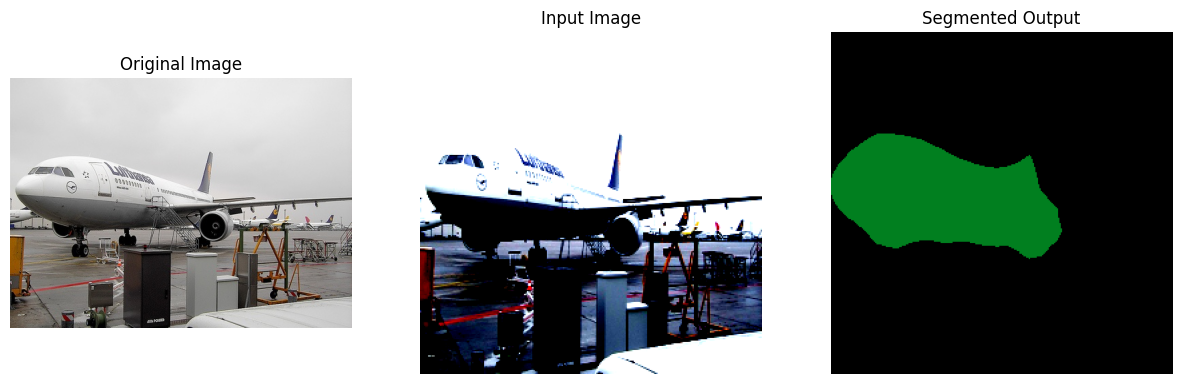

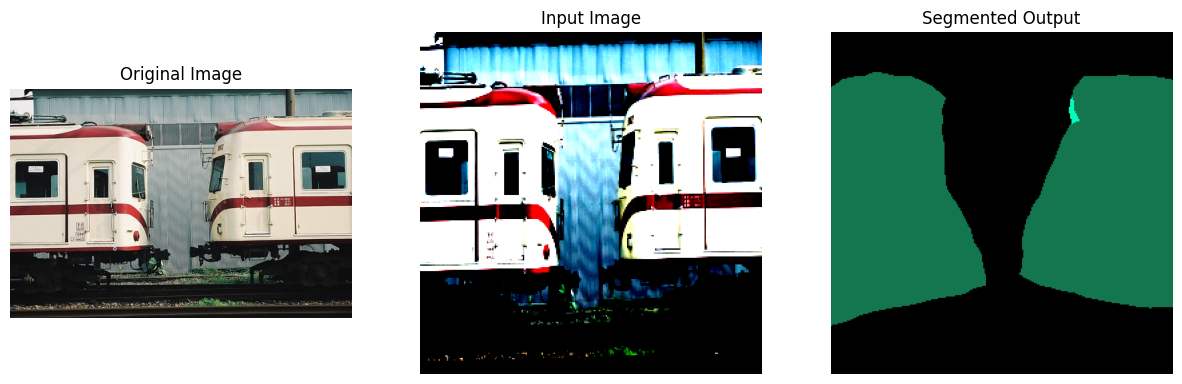

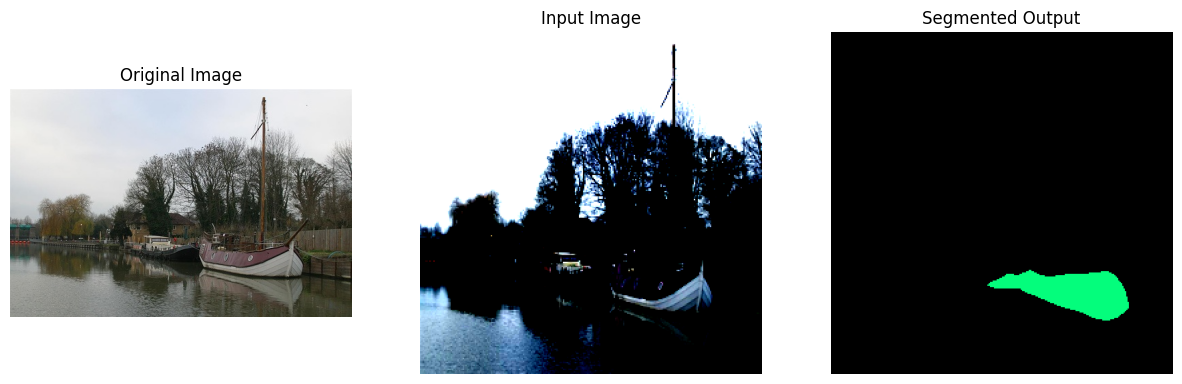

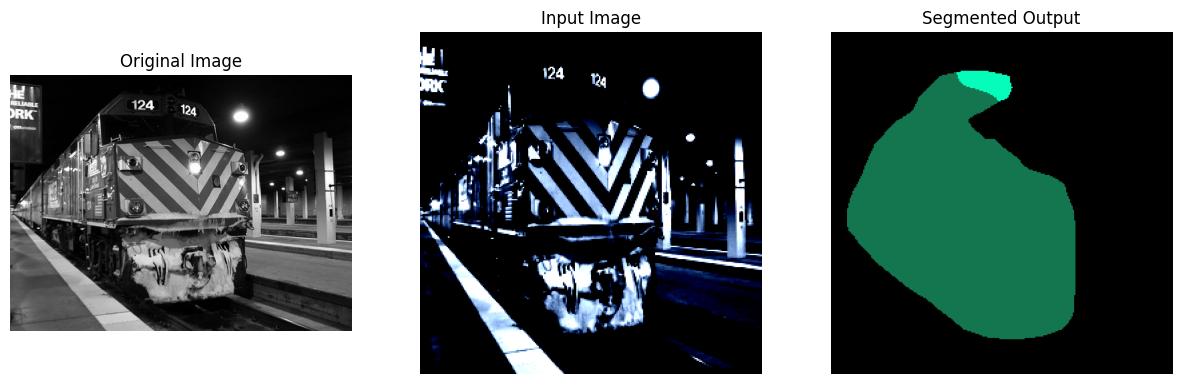

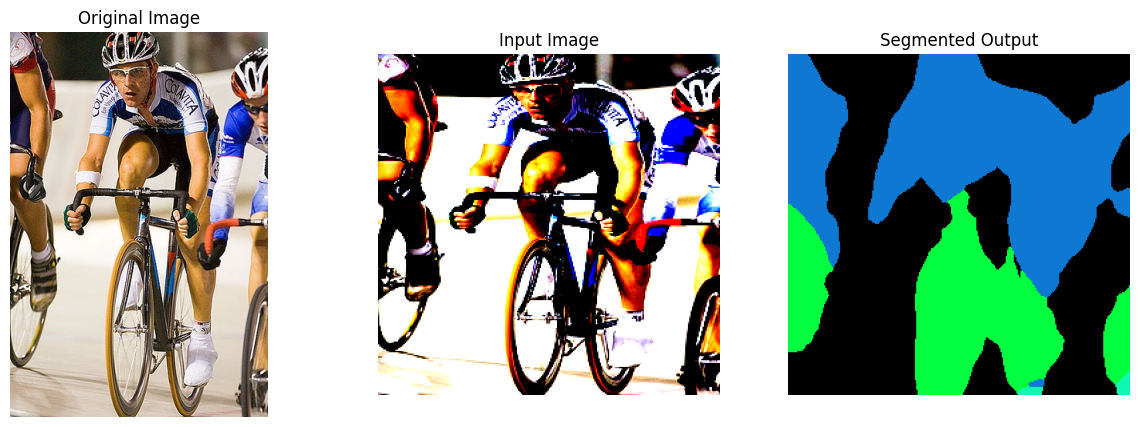

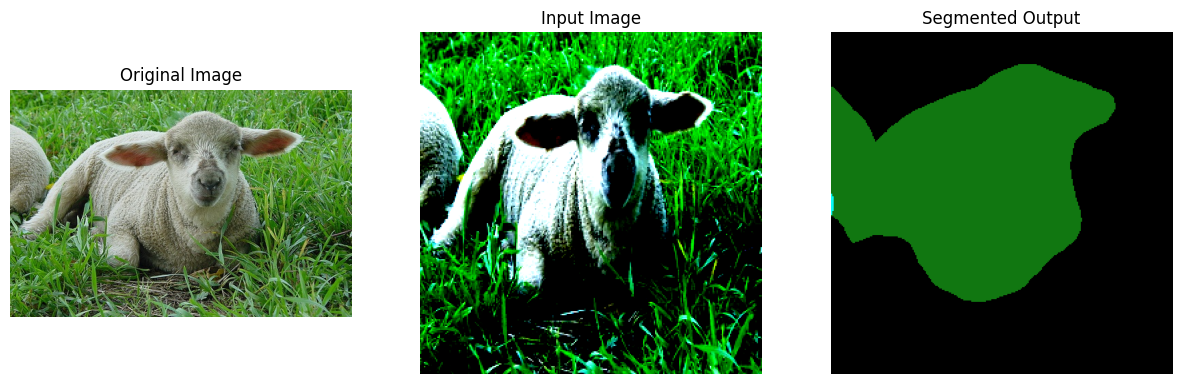

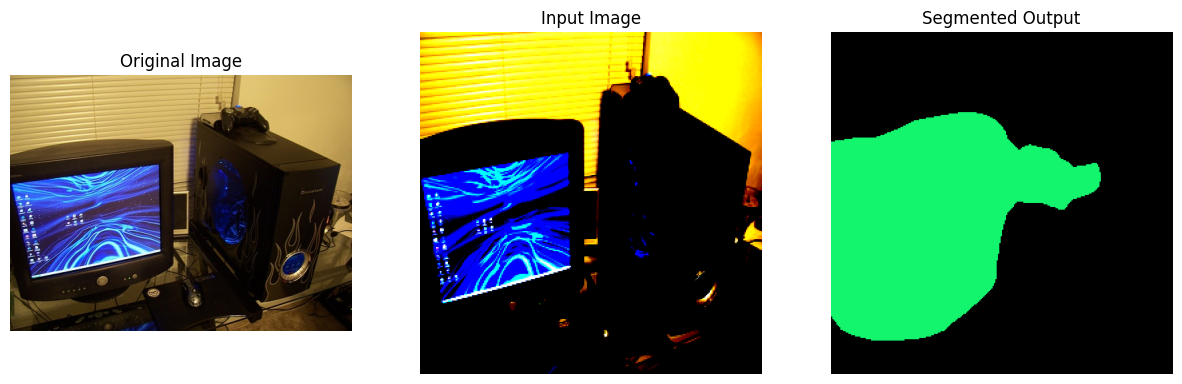

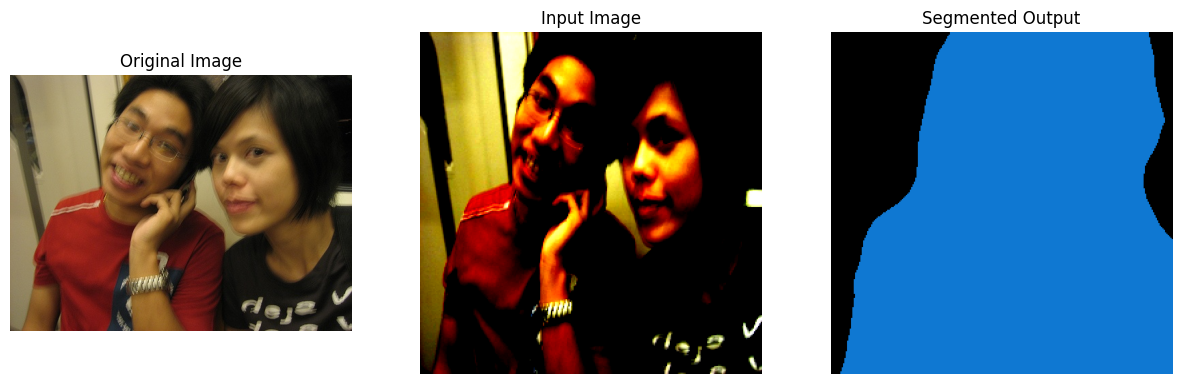

In [ ]:
# 테스트 및 시각화
model.eval()  # 모델을 평가 모드로 설정
test_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # 테스트 데이터로더 생성

with torch.no_grad():  # 테스트 시 기울기 계산 비활성화
    for i, (inputs, labels) in enumerate(test_loader):
        # 원본 이미지 불러오기
        original_image = Image.open(val_dataset.image_names[i]).convert('RGB')

        inputs = inputs.to(device)  # 입력 데이터를 GPU/CPU로 전송
        outputs = model(inputs)  # 모델에 입력 데이터를 전달하여 출력 생성
        output_predictions = outputs.argmax(1)  # 출력의 클래스 예측

        # 테스트 셋에서 첫 몇 개의 이미지를 시각화
        visualize_segmentation(original_image, inputs[0], output_predictions[0])  # 시각화 함수 호출

        if i >= 7:
            break